# [LAB-10] 11. 이원분산분석 (Two-way ANOVA)

- 정의: 2개의 명목형 독립요인(ex. 성별, 교육방법)이 
  - 연속형 종속변수의 평균에 어떤 영향을 미치는지,  
  - 그리고 두 요인 간 상호작용의 효과가 존재하는지 검정하는 통계.
- 일원분산분석처럼 이원분산분석도 분선 수행 전 가정(정규성, 등분산성) 충족 여부 확인 필요.
- 목적: 두 명목형 변수 간 상호작용 유무/효과 파악
  - -> 수준이 3개 이상(ex. 범주변수: 햇빛강도, 수준: low, med, high)인 명목형 변수(효과가 유의미할 때; p<0.05)에 대해서만 사후검정 수행

## #01. 준비작업

### 1. 패키지 참조:

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리:
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova, welch_anova

# 사후검정을 위한 라이브러리:
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

## #02. 예제1 - 햇빛 노출과 관수 빈도에 따른 식물 성장의 영향 알아보기

한 식물학자는 식물의 성장이 햇빛 노출과 관수(:물주는) 빈도에 의해 영향을 받는지 여부를 알고싶어한다.

실험은 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록하였다.

### 1. 데이터 가져오기:

In [3]:
origin = load_data('sunlight_watering_growth')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/sunlight_watering_growth.xlsx
[desc] 식물의 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록한 데이터 (출처: 방송통신대학교 통계학개론)

field    description
-------  ----------------------------------------------------------------
water    각 식물에 물을 주는 빈도 (매일:`daily`, 매주: `weekly`)
sun      각 식물이 받은 햇빛 노출량 (낮음:`low`, 중간:`med`, 높음:`high`)
height   2개월 후 각 식물의 높이 (인치)


===== 데이터 크기 확인 =====
데이터셋 크기: (120, 3)
열 갯수: 3
행 갯수: 120

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   water   120 non-null    object 
 1   sun     120 non-null    object 
 2   height  120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None


,water,sun,height
0,daily,low,4.9
1,daily,low,7.9
2,daily,low,3.9
3,daily,low,5.1
4,daily,low,5.2


> 이원분산분석에 적합한 형태는 **melt 처리된 형태**임

- 명목형변수가 2개 이상이니 subplot 형태로 분포 시각화 해야됨!
    - ex) 물을 low, med, high로 줄 때 각각을 graph화

### 2. 데이터 분포 시각화

#### (1) 관수 빈도별 햇빛 노풀 빈도에 따른 식물 높이 비교:

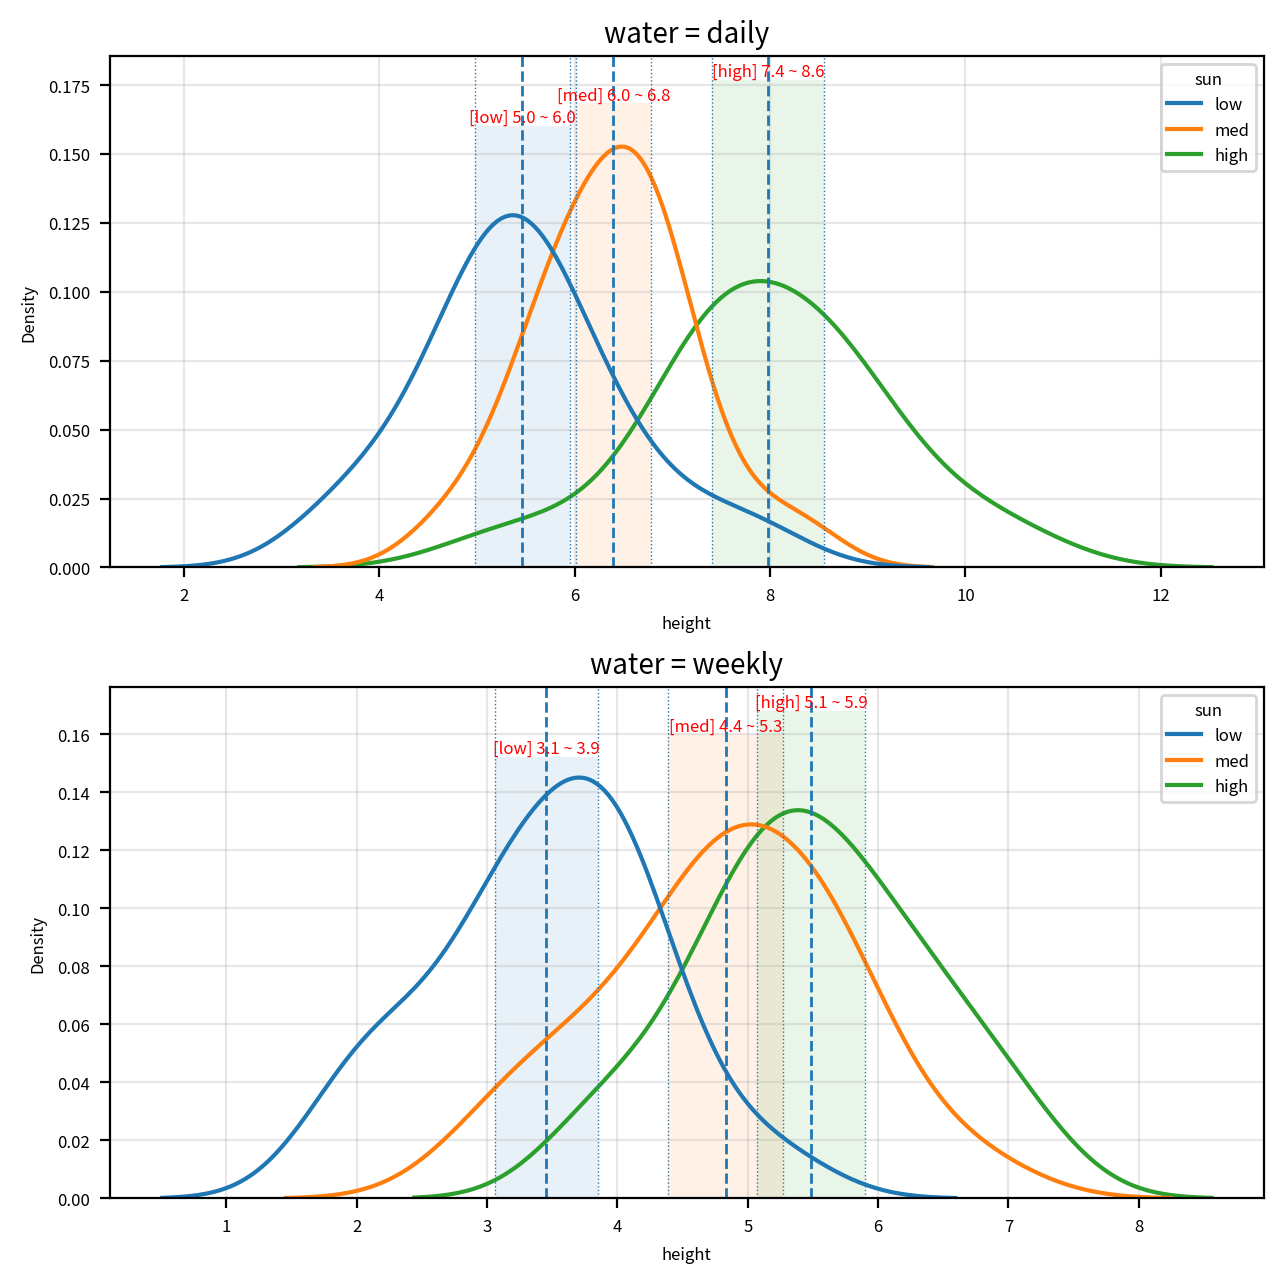

In [4]:
# 확인할 데이터 필드 (수치형):
field = 'height'
# 범주형 필드1:
group_field = 'water'
# 범주형 필드2 (hue):
hue_field = 'sun'

# 시각화 할 필드만 원본데이터에서 추출:
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

#### (2) 햇빛 노출 빈도별 관수량에 따른 식물 높이 비교:

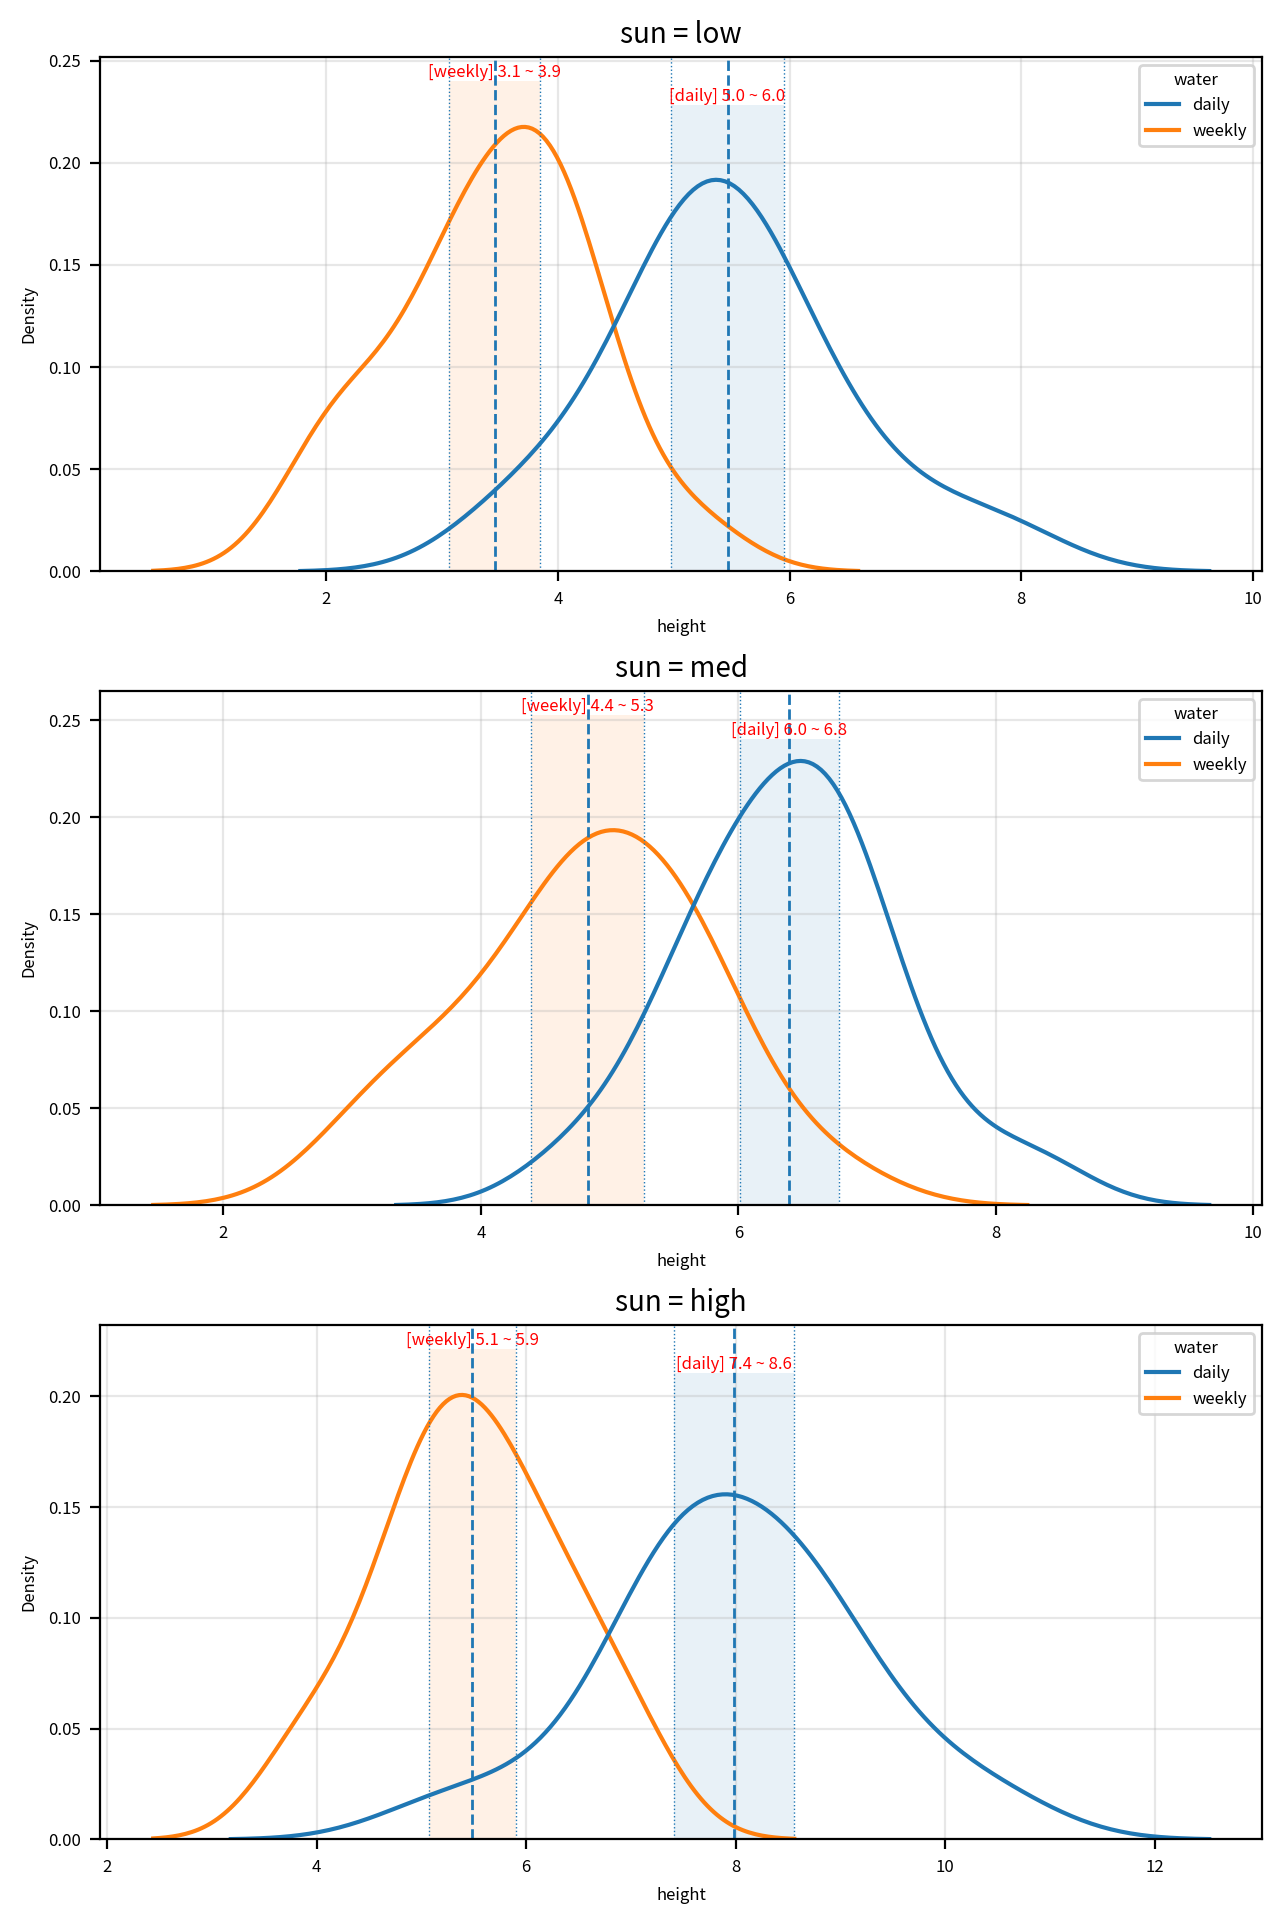

In [5]:
# 확인할 데이터 필드 (수치형):
field = 'height'
# 범주형 필드1:
group_field = 'sun'
# 범주형 필드2 (hue):
hue_field = 'water'

# 시각화 할 필드만 원본데이터에서 추출:
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 분산분석의 가정(정규성, 등분산성) 확인:

이중반복문 돌리는 이유: 수준 별 조합에 해당하는 경우의 수(daily-low, d-medium, d-high, weekly-l, w-m, w-h) 다 보고 각 경우의 수의 정규성 및 등분산성 (p>0.05) 확인을 위해

In [6]:
data = origin.copy()
xname = ['water', 'sun']  # 범주형 독립변수 2개
yname = 'height'          # 수치형 종속변수 1개

u1 = data[xname[0]].unique() # 명목형변수1의 수준들 종류
u2 = data[xname[1]].unique() # 명목형변수2의 수준들 종류
equal_var_fields = []        # 충족한 등분산성 조건 저장용 
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "fields": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

# 등분산성 검정법 선택:
if normal_dist:
    n = "Bartlett" # : 정규성 충족할 때
    s, p = bartlett(*equal_var_fields) # 모든 컬럼의 데이터 한번에
else:
    n = "Levene's" # :정규성 충족 못할 때
    s, p = levene(*equal_var_fields, 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": n,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
"daily, low",1.461514,0.481544,True
"daily, med",0.866582,0.648372,True
"daily, high",0.801917,0.669678,True
"weekly, low",0.073958,0.963697,True
"weekly, med",0.160764,0.922764,True
"weekly, high",0.052520,0.974082,True
Bartlett,4.488400,0.481437,True


### 4. 이원분산분석


#### (1) 분산분석 결과 생성:

In [7]:
xname = ['water', 'sun']
yname = 'height'

pg_anova = anova(data=origin, dv=yname, between=xname)
pg_anova

,Source,SS,DF,MS,F,p-unc,np2
0,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
1,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
2,water * sun,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


두 독립변수(water*sun)의 조합은 효과과 유의미하지 않다 (p>0.05)

#### (2) 결과 문장 생성:

In [8]:
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"→ {source}효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source}효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

→ water효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ sun효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ water * sun효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ Residual효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


ANOVA data = 설명되는 부분 + 설명되지 않는 부분(=residual)
- sum of squares: ∑($SS_(total)$) = $SS_(water)$ + $SS_(sun)$ + $SS_(water*sun)$ + $SS_(residual)$
- 'value of DoF(residual[MS])' 1/∞ 'Quality of Model'

#### (3) 사후검정:

In [10]:
xname = ['water', 'sun']  # 명목형 독립변수 2개
yname = 'height'          # 수치형 종속변수 1개
data = origin[xname + [yname]]

levels = {}           # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식의 결과 만들기 위해:
for factor in xname:                     # 명목변수 하나씩 꺼냄
    level_count = data[factor].nunique()# 꺼낸 변수의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장

pvals = {}            # 빈 딕셔너리 만들기
# 예: {'water': 1.3e-20, 'sun': 2.01e-17, 'water*sun': 0.105}:
for index, row in pg_anova.iterrows():  # 행 하나씩 꺼냄
    source_name = row['Source']         # 명목변수 이름
    p_value = row['p-unc']              # 각 명목변수의 p-value
    pvals[source_name] = p_value        # 딕셔너리에 저장

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안함")
        continue

    print(f"- 주효과 유의함 (p={p_val:.3g}) → 사후검정 수행")

    # 결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
    # 얼마나? -> 사후검정 ㄱㄱ
    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리:
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의함 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 불필요")


[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun]
- 주효과 유의함 (p=2.01e-17) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,6.7325,4.4600,2.2725,0.316503,7.180027,2.079377e-10,1.480100
1,high,med,6.7325,5.6125,1.1200,0.316503,3.538671,1.663237e-03,0.775153
2,low,med,4.4600,5.6125,-1.1525,0.316503,-3.641356,1.172021e-03,-0.888359



[water * sun] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.105) → 단순주효과 분석 불필요


## #03. 인사이트


### 1. 분석 목적:

### 2. 분석분석 주요 결과

#### 2-1. 요인별 유의성 판단:

### 3. 기술통계 및 집단별 평균 비교:

### 4. 사후검정(Post-doc) 결과:

어떤게 가장 효과가 좋은지 정도는 사후검정에서 밝히지 않는다.

### 5. 최종 결론 요약: